# Estimating how active actors will be

In this post, we will try to modelize and forecast how many movies we can expect actors to appear in in the future based on their past activity. This is a problem that bears many similarities with marketing topics such as customer analysis, and can be viewed as a Customer Lifetime Value problem. The approach we will present here differs from time series in that we do not really look associate movies with time units with attention, but rather look at aggregate numbers of movies during time ranges to fit probabilistic models.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
%matplotlib inline

In [0]:
if int(pd.__version__.split('.')[1]) < 24:
  ! pip install pandas --upgrade

In [3]:
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

--2019-04-21 23:48:49--  https://datasets.imdbws.com/title.principals.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.33.0.175, 13.33.0.30, 13.33.0.103, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.33.0.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282291234 (269M) [binary/octet-stream]
Saving to: ‘title.principals.tsv.gz’

title.principals.ts 100%[===================>] 269.21M  15.5MB/s    in 19s     

2019-04-21 23:49:09 (14.5 MB/s) - ‘title.principals.tsv.gz’ saved [282291234/282291234]

--2019-04-21 23:49:10--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.33.0.175, 13.33.0.30, 13.33.0.103, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.33.0.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103976379 (99M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>]  99.16

In [0]:
! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [0]:
cast = pd.read_csv('title.principals.tsv', sep='\t', na_values = "\\N", keep_default_na = False, 
                   usecols = ['tconst','ordering','nconst','category','job'],
                   dtype = {'tconst': str, 'ordering': 'Int64', 'nconst': str, 'category': str, 'job': str})
titles = pd.read_csv('title.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                     usecols = ['tconst','primaryTitle','startYear'],
                    dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'})
names = pd.read_csv('name.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                    usecols = ['nconst','primaryName','birthYear','deathYear'],
                   dtype = {'nconst': str, 'primaryName': str, 'birthYear': 'Int64', 'deathYear': 'Int64'})

In [0]:
startYear = 1950
endYear = 1960

In [5]:
cast.head()

,tconst,ordering,nconst,category,job
0,tt0000001,1,nm1588970,self,NaN
1,tt0000001,2,nm0005690,director,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography
3,tt0000002,1,nm0721526,director,NaN
4,tt0000002,2,nm1335271,composer,NaN


In [6]:
titles.head()

,tconst,primaryTitle,startYear
0,tt0000001,Carmencita,1894
1,tt0000002,Le clown et ses chiens,1892
2,tt0000003,Pauvre Pierrot,1892
3,tt0000004,Un bon bock,1892
4,tt0000005,Blacksmith Scene,1893


In [7]:
names["alive"] = names.deathYear.isnull()
names.head()

,nconst,primaryName,birthYear,deathYear,alive
0,nm0000001,Fred Astaire,1899,1987,False
1,nm0000002,Lauren Bacall,1924,2014,False
2,nm0000003,Brigitte Bardot,1934,NaN,True
3,nm0000004,John Belushi,1949,1982,False
4,nm0000005,Ingmar Bergman,1918,2007,False


In [0]:
classic_names = names[(names.birthYear<=startYear-10) & ((names.deathYear>=endYear) | (names.alive == True))]

In [9]:
classic_names.head()

,nconst,primaryName,birthYear,deathYear,alive
0,nm0000001,Fred Astaire,1899,1987,False
1,nm0000002,Lauren Bacall,1924,2014,False
2,nm0000003,Brigitte Bardot,1934,NaN,True
4,nm0000005,Ingmar Bergman,1918,2007,False
5,nm0000006,Ingrid Bergman,1915,1982,False


In [0]:
actors = ["Lauren Bacall", "Cary Grant", "Ingrid Bergman", "James Stewart", "Elizabeth Taylor", "Gary Cooper",
         "Marlon Brando", "Katharine Hepburn"]

In [0]:
names_actors = names[names.primaryName.isin(actors)].head(len(actors))

In [0]:
names_actors = names_actors[names_actors.deathYear >= endYear]

In [13]:
names_actors

,nconst,primaryName,birthYear,deathYear,alive
1,nm0000002,Lauren Bacall,1924,2014,False
5,nm0000006,Ingrid Bergman,1915,1982,False
7,nm0000008,Marlon Brando,1924,2004,False
10,nm0000011,Gary Cooper,1901,1961,False
25,nm0000026,Cary Grant,1904,1986,False
30,nm0000031,Katharine Hepburn,1907,2003,False
70,nm0000071,James Stewart,1908,1997,False
71,nm0000072,Elizabeth Taylor,1932,2011,False


In [0]:
classic_cast_actors = pd.merge(classic_names, cast, on = 'nconst')

In [0]:
movie_actors = pd.merge(classic_cast_actors, titles, on = 'tconst')

In [0]:
movie_list = movie_actors[['primaryName','birthYear','deathYear','category','primaryTitle','startYear']]

In [0]:
movie_list = movie_list[movie_list.category.isin(['actor','actress'])]

In [18]:
movie_list.head()

,primaryName,birthYear,deathYear,category,primaryTitle,startYear
0,Fred Astaire,1899,1987,actor,The Gay Divorcee,1934
1,Ginger Rogers,1911,1995,actress,The Gay Divorcee,1934
2,Edward Everett Horton,1886,1970,actor,The Gay Divorcee,1934
7,Fred Astaire,1899,1987,actor,Roberta,1935
8,Randolph Scott,1898,1987,actor,Roberta,1935


In [0]:
active_actors = movie_list[movie_list.startYear > startYear - 10].groupby("primaryName").agg({"startYear":'min'}).reset_index()
active_actors_list = active_actors[active_actors.startYear < startYear]
actors_list = active_actors_list["primaryName"]

In [0]:
movie_list = movie_list[movie_list.primaryName.isin(actors_list)]
movie_list_observed = movie_list[movie_list.startYear.isin(range(startYear,endYear))]
movie_list_unobserved = movie_list[movie_list.startYear.isin(range(endYear,endYear+10))]

In [0]:
movie_counts = movie_list_observed.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})
movie_counts_validation = movie_list_unobserved.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})

In [22]:
movie_counts.groupby('primaryName').agg({'numberMovies':'sum'}).head()

,numberMovies
primaryName,
'Snub' Pollard,1
A.E. Matthews,20
Aarne Laine,1
Abbas Fares,8
Abdel Aziz Mahmoud,8


In [23]:
movie_counts.head()

,primaryName,startYear,numberMovies
0,'Snub' Pollard,1955,1
1,A.E. Matthews,1951,1
2,A.E. Matthews,1952,3
3,A.E. Matthews,1954,2
4,A.E. Matthews,1956,1


In [0]:
def plot_history_actor(ax, actor_name, max_value):
  actor_history = movie_counts[movie_counts.primaryName == actor_name]
  ax.bar(actor_history.startYear, actor_history.numberMovies, color = 'firebrick')
  ax.set_xticks([i for i in range(1950,1960)])
  ax.set_yticks(np.linspace(0,max_value,max_value+1))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_history_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  max_value = movie_counts[movie_counts.primaryName.isin(actors)].numberMovies.max()
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_history_actor(ax, actor_name, max_value)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Number of movies made each year", y = 1.1, fontsize = 20)
  fig.tight_layout()

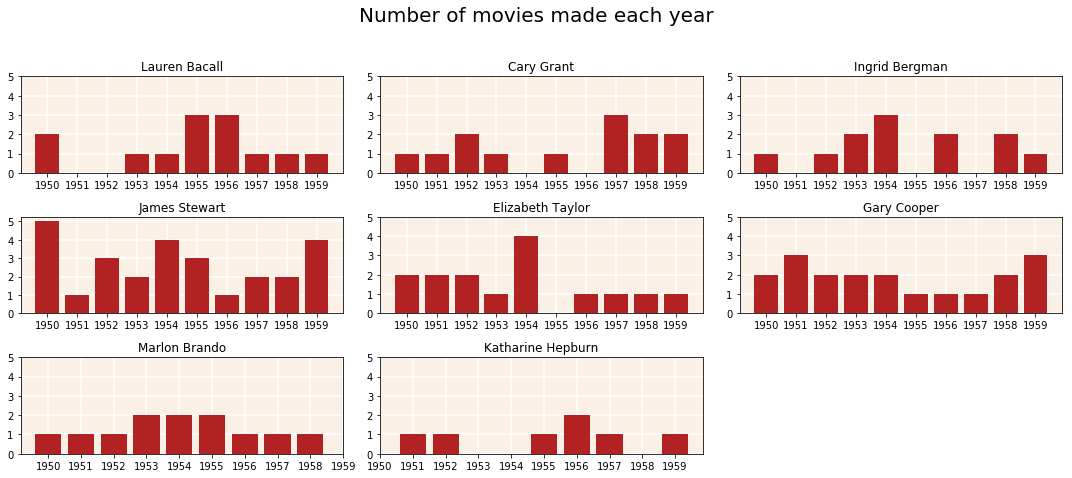

In [25]:
plot_history_actors(actors)

In [0]:
lambda_actors = movie_counts.groupby("primaryName").agg({"numberMovies" : "sum"}).reset_index()
lambda_actors["lambda"] = lambda_actors.numberMovies/(endYear - startYear)
lambda_actors = lambda_actors.merge(actors_list, on = "primaryName", how = "right").fillna(0)
lambda_actors["numberMovies"] = lambda_actors.numberMovies.astype(int)

In [27]:
lambda_actors.head()

,primaryName,numberMovies,lambda
0,'Snub' Pollard,1,0.1
1,A.E. Matthews,20,2.0
2,Aarne Laine,1,0.1
3,Abbas Fares,8,0.8
4,Abdel Aziz Mahmoud,8,0.8


In [0]:
def probability(lambda_param, t, k):
  return np.exp(-lambda_param*t)*(lambda_param*t)**k/np.math.factorial(k)

In [0]:
def plot_probability_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  k_list = np.linspace(0,40,41)
  probability_list = np.array([probability(lambda_param, t, k) for k in k_list])
  ax.plot(k_list, probability_list, color = 'firebrick')
  ax.fill_between(k_list, probability_list,  color = 'firebrick', alpha = 0.5)
  ax.axvline(x=lambda_param*t, color = 'k', linestyle = '--')
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_probability_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_probability_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Fitted probability distribution for t = " + str(t)+ " years", y = 1.1, fontsize = 20)
  fig.tight_layout()

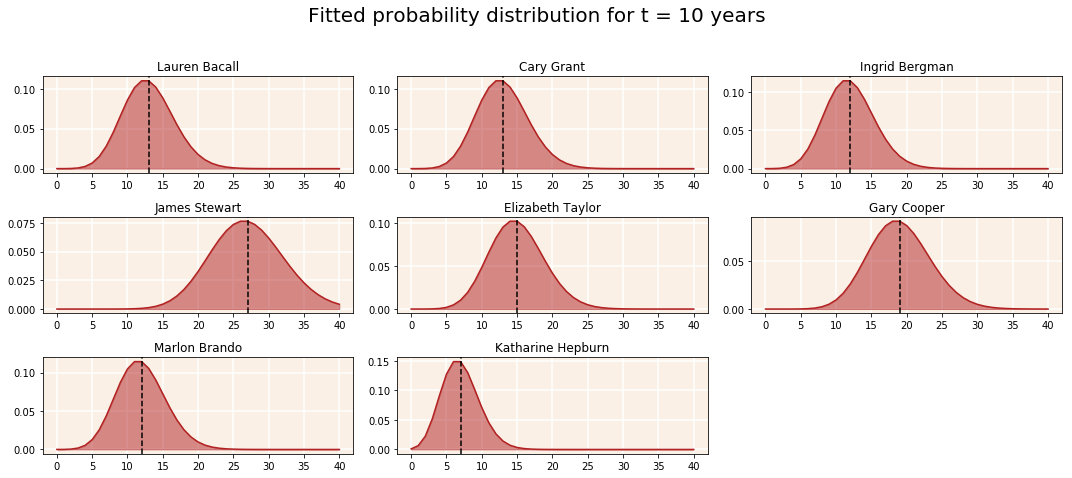

In [30]:
plot_probability_actors(actors, 10)

In [0]:
def cdf(lambda_param, t, n):
  cdf = 0
  for i in range(n):
    cdf += probability(lambda_param, t, i)
  return cdf

In [0]:
def plot_cdf_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  n_list = np.linspace(0,40,41, dtype = int)
  probability_list = np.array([1-cdf(lambda_param, t, n) for n in n_list])
  ax.bar(n_list, probability_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_cdf_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_cdf_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability of appearing in more than n movies in t = "+ str(t) +" years", y = 1.1, fontsize = 20)
  fig.tight_layout()

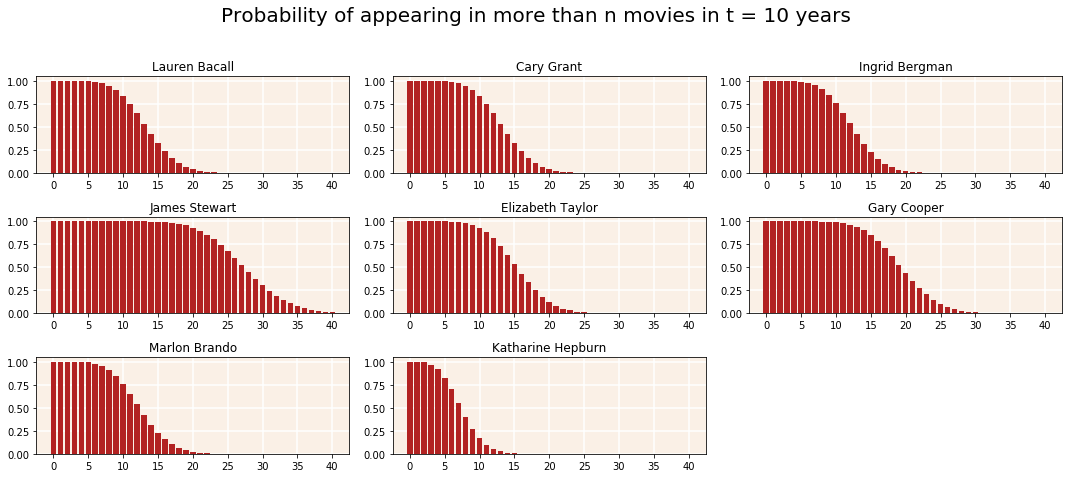

In [33]:
plot_cdf_actors(actors, 10)

In [0]:
def waiting_time(lambda_param, t):
  return np.exp(-lambda_param*(t-1)) - np.exp(-lambda_param*t)

In [0]:
def plot_waiting_time_actor(ax, actor_name):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  t_list = np.linspace(1,5,5, dtype = int)
  waiting_time_list = np.array([waiting_time(lambda_param, t) for t in t_list])
  x_axis = [str(t-1) + "-" + str(t) + " y" for t in t_list]
  ax.bar(x_axis, waiting_time_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(axis = 'y', color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_waiting_time_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_waiting_time_actor(ax, actor_name)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability distribution of waiting time between two movies in years", y = 1.1, fontsize = 20)
  fig.tight_layout()

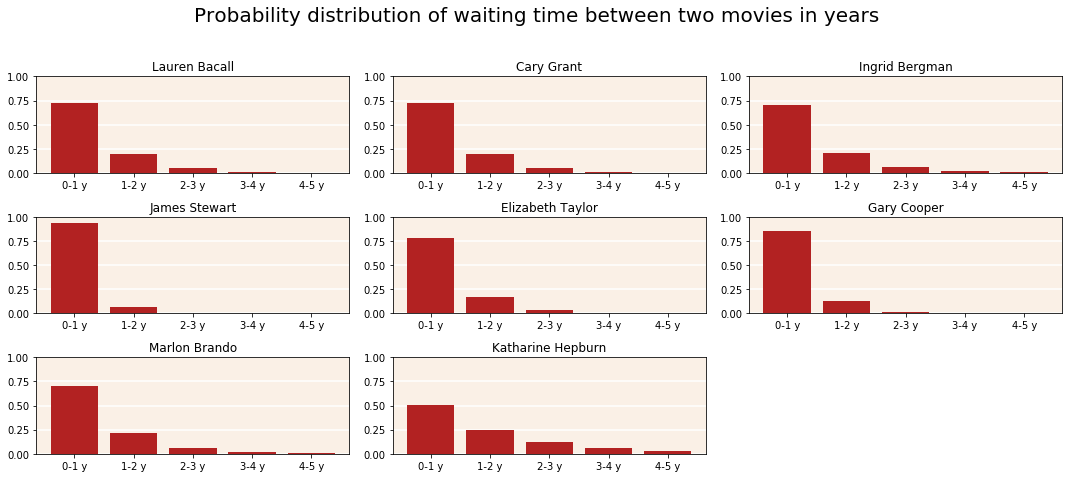

In [36]:
plot_waiting_time_actors(actors)

In [37]:
movie_counts_validation.groupby('primaryName').agg({'numberMovies':'sum'}).head()

,numberMovies
primaryName,
Aage Fønss,2
Aarne Laine,2
Aase Bye,1
Abbas Fares,4
Abdel Fatah Al Kasri,2


In [38]:
lambda_actors.head()

,primaryName,numberMovies,lambda
0,'Snub' Pollard,1,0.1
1,A.E. Matthews,20,2.0
2,Aarne Laine,1,0.1
3,Abbas Fares,8,0.8
4,Abdel Aziz Mahmoud,8,0.8


In [0]:
def compute_prediction(n,t):
  return lambda_actors["lambda"].apply(lambda x: np.exp(-x*t)*(x*t)**n/np.math.factorial(n)).sum()

In [0]:
def compute_predictions(t):
  fig, ax = plt.subplots(figsize=(10, 5))
  x_list = np.linspace(0,50,51)
  prediction_list = np.array([compute_prediction(n,t) for n in x_list])
  ax.bar(x_list, prediction_list)
  ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

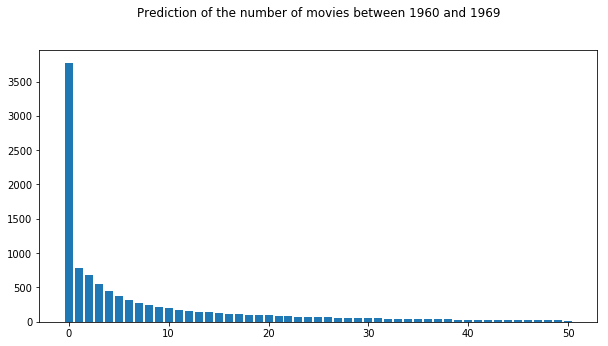

In [41]:
compute_predictions(10)

In [42]:
t = 10
total_prediction = np.sum(lambda_actors["lambda"])*t
print("For this actor sample, we can estimate they will appear in %i movies in the next %i years" % (total_prediction,t))

For this actor sample, we can estimate they will appear in 132358 movies in the next 10 years


In [43]:
real_amount = np.sum(movie_counts_validation["numberMovies"])
print("In reality, these actors appeared in %i movies during between 1960 and 1969" % real_amount)

In reality, these actors appeared in 107690 movies during between 1960 and 1969


In [44]:
movie_counts_validation.head()

,primaryName,startYear,numberMovies
0,Aage Fønss,1968,1
1,Aage Fønss,1969,1
2,Aarne Laine,1966,1
3,Aarne Laine,1967,1
4,Aase Bye,1961,1


In [0]:
total_validation = movie_counts_validation.groupby('primaryName').agg({'numberMovies':'sum'}).merge(actors_list, on = "primaryName", how = "right").fillna(0).groupby("numberMovies").agg({"numberMovies":'count'}).rename(columns = {"numberMovies":"count"}).reset_index()
total_validation = total_validation.merge(pd.DataFrame({"numberMovies":np.arange(51)}), how = "right").fillna(0).sort_values(by = "numberMovies")

In [46]:
total_validation.head()

,numberMovies,count
0,0.0,4947
1,1.0,1051
2,2.0,595
3,3.0,471
4,4.0,356


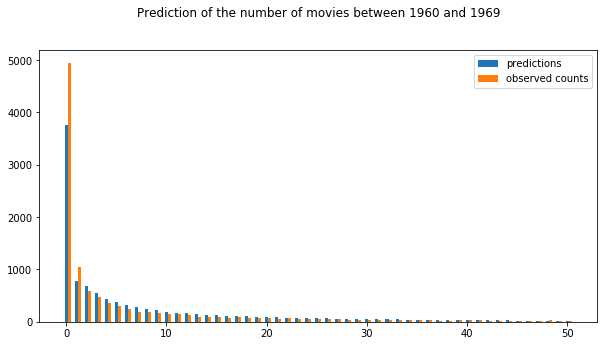

In [47]:
width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(51)
prediction_list = np.array([compute_prediction(n,t) for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

ax.bar(x_list + width, total_validation["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

In [0]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

In [50]:
data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [55]:
movie_counts.head()

,primaryName,startYear,numberMovies
0,'Snub' Pollard,1955,1
1,A.E. Matthews,1951,1
2,A.E. Matthews,1952,3
3,A.E. Matthews,1954,2
4,A.E. Matthews,1956,1


In [0]:
movie_counts_reshape = movie_counts.groupby("primaryName").agg({"numberMovies":'sum', "startYear":'max'}).reset_index().rename(columns = {"startYear":"recency","numberMovies":"frequency"})

In [76]:
movie_counts_reshape["recency"] = movie_counts_reshape.recency - startYear
movie_counts_reshape["T"] = endYear-startYear-1
movie_counts_reshape.head()

,primaryName,frequency,recency,T
0,'Snub' Pollard,1,5,9
1,A.E. Matthews,20,9,9
2,Aarne Laine,1,5,9
3,Abbas Fares,8,9,9
4,Abdel Aziz Mahmoud,8,4,9


In [0]:
blabla = movie_counts_reshape.iloc[0:332]

In [112]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(blabla['frequency'], blabla['recency'], blabla['T'])

<lifetimes.BetaGeoFitter: fitted with 332 subjects, a: 0.09, alpha: 0.53, b: 1.42, r: 0.89>

In [115]:
movie_counts_reshape.iloc[332:333]

,primaryName,frequency,recency,T
332,Anita Coleman,604,1,9
